J41112 Шваб Кирилл
# <center>Лабораторная работа 3</center>
<center>Вариант 15</center>

## Задание 1
***Условие:***

*Пусть цена **Европейского Put** опциона с* $X=500\$$ *равна* $3\$,$ *а текущая цена акции равна* $S=493\$.$ *Найдите цену **Американского Call** опциона с тем же страйком, если* $r = 1\%$ *и* $T = 3.$ *Ответ округлите до целых.*

***Решение:***

*Цены Европейских Put и Call опционов с одинаковыми параметрами связаны формулой:* $$C-P=S(t)-Xe^{-r(T-t)}$$

$$C=S(t)-Xe^{-r(T-t)}+P$$

In [6]:
from math import exp

def ex_1(s=493,x = 500, r = 1, dt = 3, put = 3):
    """Задание 1. Вычисление Call опциона"""
    return round(s - x * exp(-r/100 * dt) + put, 2)

In [7]:
ex_1()

10.78

*Цена **Европейского Call** опциона равна* $10,78\$.$

*Однако цена **Американского Call** опциона равна цене **Европейского**, т.е. в каждый момент времени, при любой цене базового актива, досрочное исполнение **Call** опциона не является оптимальным.*

***Ответ:*** *цена **Американского Call** опциона при заданных параметрах **Европейского Put** опциона равна* $10,78\$$

### Задание 2

Реализуем функции для подсчета:
- Fair Value Европейских опционов
- Payoff европейских опционов

In [18]:
from math import log, sqrt, exp
from scipy.stats import norm
import numpy as np
from scipy.special import comb

import matplotlib.pyplot as plt
import math

from optionprice import Option

In [15]:
cdf = norm.cdf
ASSET_PRICE = 70
STRIKE_PRICE = 70
SIGMA = 0.4
R = 0.05
T = 2

N = np.arange(20, 401)


In [16]:
# Справедливая цена для европейского Колл опциона
def fair_value_call(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T):
    return cdf(d1(s, x, r, sigma, t)) * s - cdf(d2(s, x, r, sigma, t)) * x * exp(-r * t)


# Справедливая цена для европейского Пут опциона
def fair_value_put(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T):
    return cdf(-d2(s, x, r, sigma, t)) * x * exp(-r * t) - cdf(-d1(s, x, r, sigma, t)) * s


def d1(s, x, r, sigma, t):
    return (log(s / x) + (r + pow(sigma, 2) / 2) * t) / (sigma * sqrt(t))


def d2(s, x, r, sigma, t):
    return d1(s, x, r, sigma, t) - sigma * sqrt(t)


# Payoff для Call опциона
def payoff_call(s=ASSET_PRICE, x=STRIKE_PRICE):
    return max(s - x, 0)


# Payoff для Put опциона
def payoff_put(s=ASSET_PRICE, x=STRIKE_PRICE):
    return max(x - s, 0)


- Цены на $i$-том шаге из цен $i+1$-го шага

$$V=e^{-rdt}(pV^++(1-p)V^-)$$

In [17]:
def price_i(v_up, v_down, p, r, t):
    return exp(-r * t) * (p * v_up + (1 - p) * v_down)

- Цен **Европейских** опционов при помощи биномиальной модели

$$C=e^{-rT}\cdot\sum_{i=0}^{n}{n \choose i}p^{i}(1-p)^{n-i}\cdot max(Su^{i}d^{n-i}-X,0)$$

$$P=e^{-rT}\cdot\sum_{i=0}^{n}{n \choose i}p^{i}(1-p)^{n-i}\cdot max(X-Su^{i}d^{n-i},0)$$

$$u = e^{\sigma \sqrt{δ t}}$$
$$d = e^{-\sigma \sqrt{δ t}}$$
$$p = \frac{e^{r δ t}-d}{u-d}$$


In [19]:
def binominal_call(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T, n=N):
    """Биномиальная модель для европейского Call опциона"""
    dt = t / n
    return (exp(-r * t) *
            np.sum([comb(n, i) * p(sigma, dt, r)**i * (1 - p(sigma, dt, r))**(n - i) *
                    payoff_call(s * u(sigma, dt)**i * d(sigma, dt)**(n - i), x=x) for i in range(n)]))


def binominal_put(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T, n=N):
    """Биномиальная модель для европейского Put опциона"""
    dt = t / n
    return (exp(-r * T) *
            np.sum([comb(n, i) * p(sigma, dt, r)**i * (1 - p(sigma, dt, r))**(n - i) *
                    payoff_put(s * u(sigma, dt)**i * d(sigma, dt)**(n - i), x) for i in range(n)]))

# Функции для расчета парметров u, d, p


def u(sigma, dt):
    return exp(sigma * sqrt(dt))


def d(sigma, dt):
    return exp(-sigma * sqrt(dt))


def p(sigma, dt, r):
    return (exp(r * dt) - d(sigma, dt)) / (u(sigma, dt) - d(sigma, dt))


In [29]:

# Функция цены Американского Put опциона при помощи биномиальной модели
def binominal_american_price(s=ASSET_PRICE, x=STRIKE_PRICE, n=N, sigma=SIGMA, r=R, t=T, type=None):
    # Расчитываем коэффициенты u, d, p, dt
    dt = t / n
    u_value = u(sigma, dt)
    d_value = d(sigma, dt)
    p_value = p(sigma, dt, r)

    # Создаем дерево длинной N
    tree = {i: [] for i in range(n + 1)}
    tree[0].append(s)

    # Прямой ход заполнения дерева
    for i in range(1, n + 1):
        for j in range(len(tree[i - 1])):
            if j == 0:
                tree[i].append(tree[i - 1][j] * u_value)
                tree[i].append(tree[i - 1][j] * d_value)
            else:
                tree[i].append(tree[i - 1][j] * d_value)

    if type == 'Put':
        # Расчет Payoff для итоговых значений опциона в момент Maturity Date
        for i in range(n + 1):
            tree[n][i] = payoff_put(tree[n][i], x)

        # Обратный ход заоплнения дерева
        for i in range(n - 1, -1, -1):
            for j in range(len(tree[i])):
                tree[i][j] = max(payoff_put(tree[i][j], x),
                                 price_i(tree[i + 1][j], tree[i + 1][j + 1], p_value, r, dt))

    elif type == 'Call':
        # Расчет Payoff для итоговых значений опциона в момент Maturity Date
        for i in range(n + 1):
            tree[n][i] = payoff_call(tree[n][i], x)

        # Обратный ход заоплнения дерева
        for i in range(n - 1, -1, -1):
            for j in range(len(tree[i])):
                tree[i][j] = max(payoff_call(tree[i][j], x),
                                 price_i(tree[i + 1][j], tree[i + 1][j + 1], p_value, r, dt))

    return tree[0][0]


In [37]:
# Построим графики зависимости цен в биномиальной модели от числа шагов N
BinPutAmerican, BinCallAmerican = [], []
BinPutEuropian, BinCallEuropian = [], []
BlackSholesPut, BlackSholesCall = [], []

bin_american_put_arr = [binominal_american_price(n=i, type='Put') for i in N]
bin_american_call_arr = [binominal_american_price(n=i, type='Call') for i in N]
bin_put_arr = [binominal_put(n=i) for i in N]
bin_call_arr = [binominal_call(n=i) for i in N]

fair_value_call_arr = [fair_value_call() for i in N]
fair_value_put_arr = [fair_value_put() for i in N]

for i in N:
    # Американские опционы - биномиальная модель
    BinPutAmerican.append(binominal_american_price(n=i, type='Put'))
    BinCallAmerican.append(binominal_american_price(n=i, type='Call'))

    # Европейские опционы - биномиальная модель
    BinPutEuropian.append(binominal_put(n=i))
    BinCallEuropian.append(binominal_call(n=i))

    # Точная цена Black-Sholes
    BlackSholesPut.append(fair_value_put())
    BlackSholesCall.append(fair_value_call())


In [38]:
# Расчет цены Американского опциона при помощи библиотеки Option-Price при N=2000
option_price_result = []

# Так как по условию задачи T = 2, то установим в Option t = 730, что равняется количествую дней за 2 года
for i in N:
    option_price_result.append(Option(european=False, kind='put',\
        s0=70, k=70, r=0.05, sigma=0.4, dv=0, t=730)\
        .getPrice(method='BT', iteration=2000))

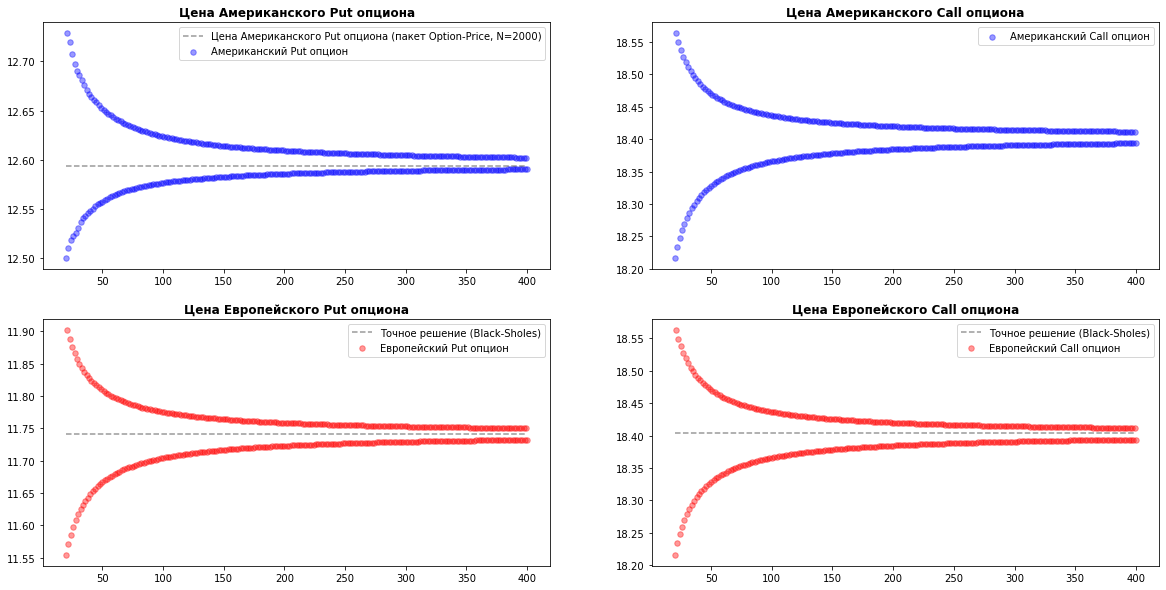

In [39]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.scatter(N, bin_american_put_arr, c='blue', alpha=0.4, s=30, label='Американский Put опцион')
plt.plot(N, option_price_result , c='black', ls='--', alpha=0.4, label='Цена Американского Put опциона (пакет Option-Price, N=2000)')
plt.title('Цена Американского Put опциона', fontweight="bold")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(N, bin_american_call_arr, c='blue', alpha=0.4, s=30, label='Американский Call опцион')
plt.title('Цена Американского Call опциона', fontweight="bold")
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(N, bin_put_arr, c='red', alpha=0.4, s=30, label='Европейский Put опцион')
plt.plot(N, fair_value_put_arr, c='black', ls='--', alpha=0.4, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Put опциона', fontweight="bold")
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(N, bin_call_arr, c='red', alpha=0.4, s=30, label='Европейский Call опцион')
plt.plot(N, fair_value_call_arr, c='black', ls='--', alpha=0.4, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Call опциона', fontweight="bold")
plt.legend()

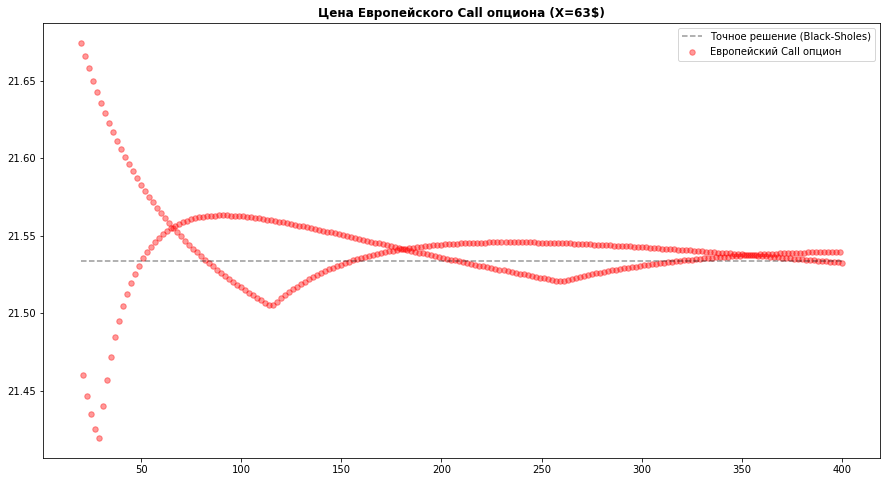

In [36]:
BinCallEuropian2 = []
BlackSholesCall2 = []

for i in N:
    BinCallEuropian2.append(binominal_call(x = 63,n = i))
    BlackSholesCall2.append(fair_value_call(x = 63))
    
plt.figure(figsize=(15, 8))
plt.scatter(N, BinCallEuropian2, c='red', alpha=0.4, s=30, label='Европейский Call опцион')
plt.plot(N, BlackSholesCall2, c='black', ls='--', alpha=0.4, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Call опциона (X=63$)', fontweight="bold")
plt.legend()